In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)  # p<0.05, Stationary

In [3]:
ten_stocks_close = pd.read_csv('Top 10 stocks.csv')

In [4]:
pool = ["600094.XSHG",    
        "600160.XSHG", 
        "600008.XSHG",
        "600903.XSHG",
        "000959.XSHE",
        "600970.XSHG",
        "002302.XSHE",
        "600823.XSHG",
        "002503.XSHE",
        "600664.XSHG"]

In [5]:
close_price = ten_stocks_close['600664.XSHG'].dropna()

## Ljung Box Test on close price

In [6]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(close_price, lags=[12], return_df=True) # The p-value closes to 0. Has dependency

,lb_stat,lb_pvalue
12,11254.433318,0.0


## Stationarity on close price first

In [7]:
test_stationarity(close_price) # p-value is larger than 0.05. Has unit root

Results of Dickey-Fuller Test:
Test Statistic                  -0.749147
p-value                          0.833605
#Lags Used                      16.000000
Number of Observations Used    983.000000
Critical Value (1%)             -3.437020
Critical Value (5%)             -2.864485
Critical Value (10%)            -2.568338
dtype: float64


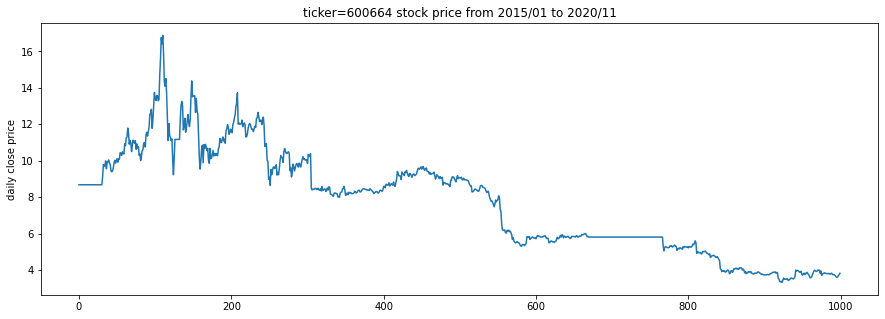

In [8]:
# visualize daily close data, lable y = column 1, ticker = 600664
close_price.plot(figsize=(15,5))
plt.ylabel('daily close price')
plt.title('ticker=600664 stock price from 2015/01 to 2020/11')
plt.show()

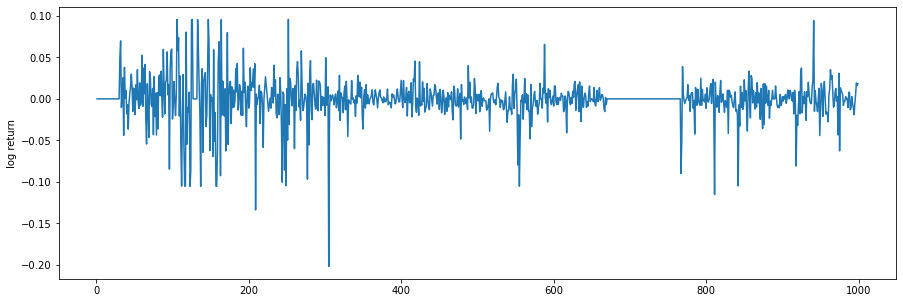

In [9]:
log_rtn = np.log(close_price).diff(1).dropna()
log_rtn.plot(figsize=(15,5))
plt.ylabel('log return')
plt.show()

## Test stationarity

In [10]:
test_stationarity(log_rtn) #p-value is small, it's stationary

Results of Dickey-Fuller Test:
Test Statistic                 -30.737639
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
dtype: float64


## ACF & PACF

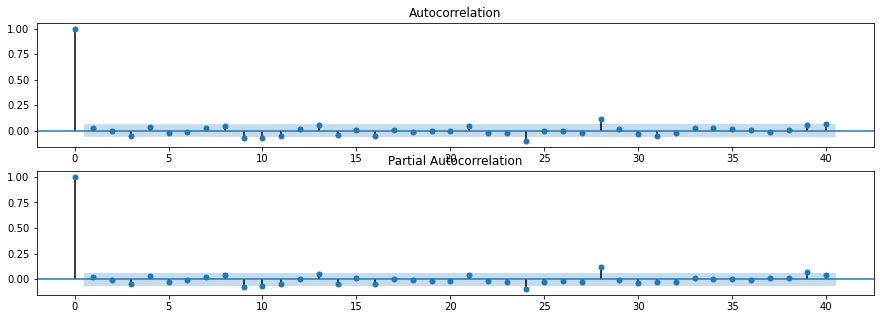

In [11]:
# acf & pacf for log return
import statsmodels.api as sm
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_rtn, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_rtn, lags=40, ax=ax2)

## Distribution of log return

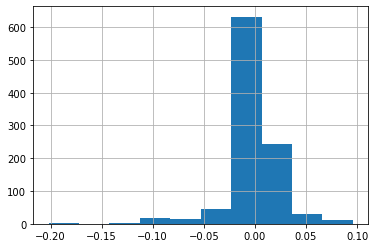

In [12]:
log_rtn.hist()
plt.show()

## Fit ARMA Model

In [13]:
import pandas as pd
import itertools
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA

p = range(5)
q = range(5)

combinations = list(itertools.product(p, q))
combinations = combinations[1:] # Drop (0,0)
def train_ARMA(param):
    try:
        p = param[0]
        q = param[1]
        model = ARIMA(log_rtn, order=(p,0,q))

        model_fit = model.fit(disp=0)

        ljung_p = sm.stats.acorr_ljungbox(model_fit.resid, lags=[12], return_df=True).values[0][1]
        aic = model_fit.aic
        return {'p': p, 'q': q, 'ljung_p': ljung_p, 'aic': aic}
    except:
        print(param)

results = pd.DataFrame(columns=['p', 'q', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_ARMA(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

,p,q,ljung_p,aic
0,0.0,1.0,0.057513,-4484.260441
4,1.0,0.0,0.057178,-4484.252860
18,3.0,4.0,0.116927,-4483.805968
11,2.0,2.0,0.229511,-4483.527402
10,2.0,1.0,0.120063,-4483.422025
6,1.0,2.0,0.118816,-4483.362608
2,0.0,3.0,0.165966,-4483.266166
14,3.0,0.0,0.146210,-4482.945056
15,3.0,1.0,0.219391,-4482.582802
7,1.0,3.0,0.204859,-4482.467918


## GARCH

In [13]:
mean = log_rtn.mean() # The mean closes to 0

### Check if volatility time dependency

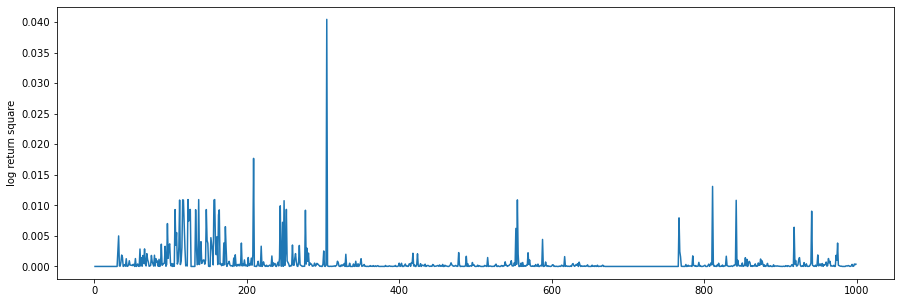

In [15]:
#log return square 
log_rtn_square = np.square(log_rtn - mean)
log_rtn_square.plot(figsize=(15,5))
plt.ylabel('log return square')
plt.show()

In [18]:
import statsmodels.api as sm

p_2 = sm.stats.acorr_ljungbox(log_rtn_square, lags=[40], return_df=True)['lb_pvalue'].values[0] # log return square is white noise if p < 0.05

print(f"P-value for squared log return: {p_2}")
if (p_2<0.05):
    print("Conclusion: Has ARCH's property in log rtn")
else:
    print("Conclusion: No ARCH's property in log rtn")

P-value for squared log return: 1.330901248693321e-71
Conclusion: Has ARCH's property in log rtn


In [17]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,4)
q = range(1,4)

combinations = list(itertools.product(p, q))

def train_GARCH(param):
    p = param[0]
    q = param[1]
    model = arch_model(log_rtn, mean='constant', p=p, q=q)
    
    res = model.fit(update_freq=0)
    
    ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
    aic = res.aic
    
    return {'p':p, 'q': q, 'alpha': res.params['alpha[1]'], 'beta': res.params['beta[1]'], 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'alpha', 'beta', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_GARCH(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2447.8370603941576
            Iterations: 16
            Function evaluations: 128
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2449.1075158514004
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2450.109110784329
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2441.172978405985
            Iterations: 3
            Function evaluations: 43
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2462.12534832619
            Iterations: 27
            Function evaluat

,p,q,alpha,beta,ljung_p,aic
4,2.0,2.0,0.139243,1.873487e-11,0.970299,-4912.250697
2,1.0,3.0,0.100000,2.933332e-01,0.957650,-4888.218222
1,1.0,2.0,0.100000,4.399999e-01,0.963730,-4888.215032
0,1.0,1.0,0.100053,8.799479e-01,0.965258,-4887.674121
5,2.0,3.0,0.050000,2.933332e-01,0.926633,-4882.486359
3,2.0,1.0,0.050000,8.799997e-01,0.942755,-4872.345957
8,3.0,3.0,0.033443,2.933002e-01,0.911616,-4866.076959
7,3.0,2.0,0.033340,4.399979e-01,0.924182,-4863.611852
6,3.0,1.0,0.033376,8.799612e-01,0.930520,-4857.446073
